In [1]:
import torch

import torch.nn as nn

import torch.optim as optim

from torch.optim import lr_scheduler

import numpy as np

import torchvision

from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt

import time

import os

import copy



mean = np.array([0.5, 0.5, 0.5])

std = np.array([0.25, 0.25, 0.25])



data_transforms = {

    'train': transforms.Compose([

        transforms.RandomResizedCrop(224),

        transforms.RandomHorizontalFlip(),

        transforms.ToTensor(),

        transforms.Normalize(mean, std)

    ]),

    'val': transforms.Compose([

        transforms.Resize(256),

        transforms.CenterCrop(224),

        transforms.ToTensor(),

        transforms.Normalize(mean, std)

    ]),

}

In [ ]:
data_dir = 'DATA/trainPhase4/data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),

                                          data_transforms[x])

                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=2,

                                             shuffle=True, num_workers=0)

              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(class_names)





def imshow(inp, title):

    """Imshow for Tensor."""

    inp = inp.numpy().transpose((1, 2, 0))

    inp = std * inp + mean

    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)

    plt.title(title)

    plt.show()



['Obs', 'def', 'nor']


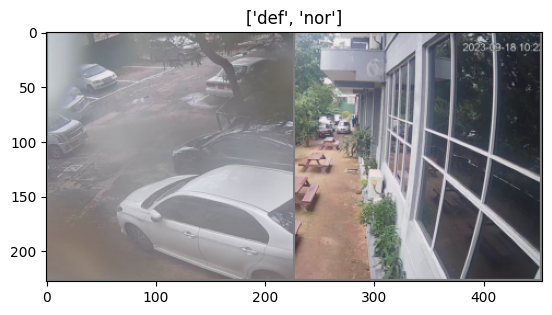

In [9]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

# Get a batch of training data

inputs, classes = next(iter(dataloaders['train']))



# Make a grid from batch

out = torchvision.utils.make_grid(inputs)



imshow(out, title=[class_names[x] for x in classes])



def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    since = time.time()



    best_model_wts = copy.deepcopy(model.state_dict())

    best_acc = 0.0



    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        print('-' * 10)



        # Each epoch has a training and validation phase

        for phase in ['train', 'val']:

            if phase == 'train':

                model.train()  # Set model to training mode

            else:

                model.eval()   # Set model to evaluate mode



            running_loss = 0.0

            running_corrects = 0



            # Iterate over data.

            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)

                labels = labels.to(device)



                # forward

                # track history if only in train

                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)

                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)



                    # backward + optimize only if in training phase

                    if phase == 'train':

                        optimizer.zero_grad()

                        loss.backward()

                        optimizer.step()



                # statistics

                running_loss += loss.item() * inputs.size(0)

                running_corrects += torch.sum(preds == labels.data)



            if phase == 'train':

                scheduler.step()



            epoch_loss = running_loss / dataset_sizes[phase]

            epoch_acc = running_corrects.double() / dataset_sizes[phase]



            print('{} Loss: {:.4f} Acc: {:.4f}'.format(

                phase, epoch_loss, epoch_acc))
            
            train_loss.append(epoch_loss)
            train_acc.append(epoch_acc)



            # deep copy the model

            if phase == 'val' and epoch_acc > best_acc:

                best_acc = epoch_acc

                best_model_wts = copy.deepcopy(model.state_dict())
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)



        print()



    time_elapsed = time.time() - since

    print('Training complete in {:.0f}m {:.0f}s'.format(

        time_elapsed // 60, time_elapsed % 60))

    print('Best val Acc: {:4f}'.format(best_acc))



    # load best model weights

    model.load_state_dict(best_model_wts)

    return model



In [ ]:
model = models.alexnet(pretrained=True)
print(model)
num_classes = 3  # number of classes 3



/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Replace the final classifier
model.classifier[6] = torch.nn.Linear(4096, num_classes)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [13]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [14]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.0887 Acc: 0.9689
val Loss: 0.0184 Acc: 0.9972

Epoch 1/29
----------
train Loss: 0.0518 Acc: 0.9827
val Loss: 0.0798 Acc: 0.9666

Epoch 2/29
----------
train Loss: 0.0425 Acc: 0.9860
val Loss: 0.3007 Acc: 0.9485

Epoch 3/29
----------
train Loss: 0.0359 Acc: 0.9880
val Loss: 0.0828 Acc: 0.9708

Epoch 4/29
----------
train Loss: 0.0344 Acc: 0.9890
val Loss: 0.0660 Acc: 0.9753

Epoch 5/29
----------
train Loss: 0.0278 Acc: 0.9914
val Loss: 0.1553 Acc: 0.9653

Epoch 6/29
----------
train Loss: 0.0267 Acc: 0.9915
val Loss: 0.1021 Acc: 0.9725

Epoch 7/29
----------
train Loss: 0.0201 Acc: 0.9940
val Loss: 0.1422 Acc: 0.9662

Epoch 8/29
----------
train Loss: 0.0176 Acc: 0.9944
val Loss: 0.1673 Acc: 0.9644

Epoch 9/29
----------
train Loss: 0.0153 Acc: 0.9955
val Loss: 0.1686 Acc: 0.9646

Epoch 10/29
----------
train Loss: 0.0132 Acc: 0.9958
val Loss: 0.1820 Acc: 0.9638

Epoch 11/29
----------
train Loss: 0.0125 Acc: 0.9962
val Loss: 0.1925 Acc: 0.9623

Ep

In [ ]:
# Saving PyTorch model

torch.save(model.state_dict(), 'alexnetPhase4.pth')

torch.save(optimizer.state_dict(), "alexnetoptimPhase4.pth")

(0.9689103681929151, 0.9972386587771203, 0.9827113746200986, 0.9666009204470742, 0.9859997010612326, 0.9484549638395792, 0.9879926261770714, 0.9708086785009862, 0.9889890887349908, 0.9752794214332675, 0.9913805988739973, 0.9652859960552268, 0.9914802451297893, 0.9725180802103879, 0.9940212246524837, 0.96620644312952, 0.9943699865477554, 0.9643655489809335, 0.9955159184893627, 0.964628533859303, 0.9957650341288425, 0.9638395792241946, 0.9961636191520103, 0.9622616699539777, 0.9954660953614668, 0.9623931623931624, 0.9953166259777788, 0.9609467455621301, 0.996761496686762, 0.9610782380013149, 0.9962632654078023, 0.9616042077580539, 0.9964127347914902, 0.9619986850756082, 0.9953166259777788, 0.9623931623931624, 0.9963130885356982, 0.9622616699539777, 0.9959643266404264, 0.9625246548323471, 0.9958148572567386, 0.9626561472715318, 0.9962632654078023, 0.9626561472715318, 0.9966120273030741, 0.9627876397107166, 0.996562204175178, 0.9626561472715318, 0.996562204175178, 0.9626561472715318, 0.995

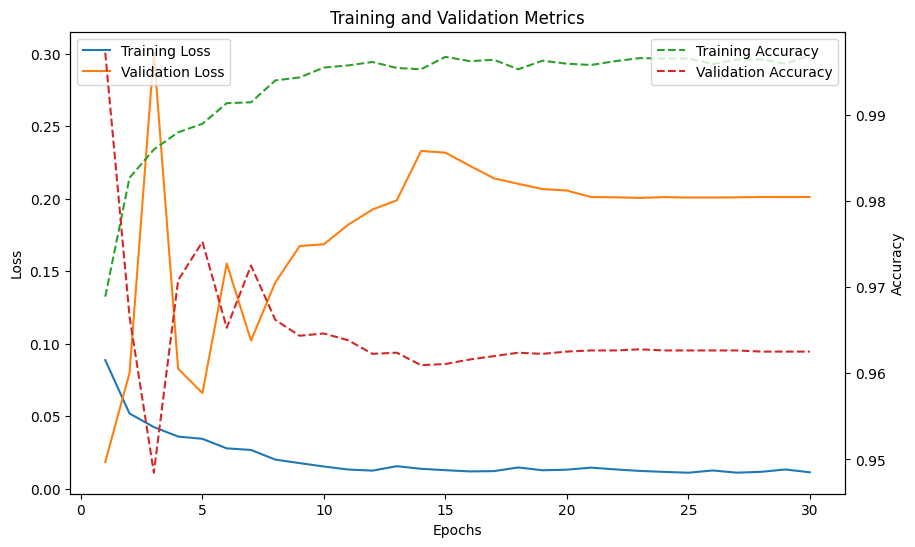

In [ ]:


tensor_tuple = train_acc

# Extract the first element of each tensor in the tuple
float_tuple = tuple(tensor.item() for tensor in tensor_tuple)

# Print the float tuple
print(float_tuple)


def separate_even_odd_indexes(float_tuple):
  train_accuracy = tuple(ele for idx, ele in enumerate(float_tuple) if idx % 2 == 0)
  valid_accuracy = tuple(ele for idx, ele in enumerate(float_tuple) if idx % 2 != 0)
  return train_accuracy, valid_accuracy


train_accuracyy, valid_accuracyy = separate_even_odd_indexes(float_tuple)


#Losses
def separate_even_odd_indexes(train_loss):
  trainig_loss = tuple(ele for idx, ele in enumerate(train_loss) if idx % 2 == 0)
  val_loss = tuple(ele for idx, ele in enumerate(train_loss) if idx % 2 != 0)
  return trainig_loss, val_loss


trainig_loss, val_loss = separate_even_odd_indexes(train_loss)

print(trainig_loss)
print(val_loss)

import matplotlib.pyplot as plt




# Sample data 

epochs = [1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]

train_losses = trainig_loss

val_losses = val_loss

train_accuracies = train_accuracyy

val_accuracies = valid_accuracyy



fig, ax1 = plt.subplots(figsize=(10, 6))





ax1.plot(epochs, train_losses, label='Training Loss', color='tab:blue')

ax1.plot(epochs, val_losses, label='Validation Loss', color='tab:orange')

ax1.set_xlabel('Epochs')

ax1.set_ylabel('Loss', color='black')

ax1.tick_params(axis='y', labelcolor='black')

ax1.legend(loc='upper left')





ax2 = ax1.twinx()





ax2.plot(epochs, train_accuracies, label='Training Accuracy', linestyle='--', color='tab:green')

ax2.plot(epochs, val_accuracies, label='Validation Accuracy', linestyle='--', color='tab:red')

ax2.set_ylabel('Accuracy', color='black')

ax2.tick_params(axis='y', labelcolor='black')

ax2.legend(loc='upper right')



plt.title('Training and Validation Metrics')

plt.xlabel('Epochs')



# Show the combined plot

plt.show()



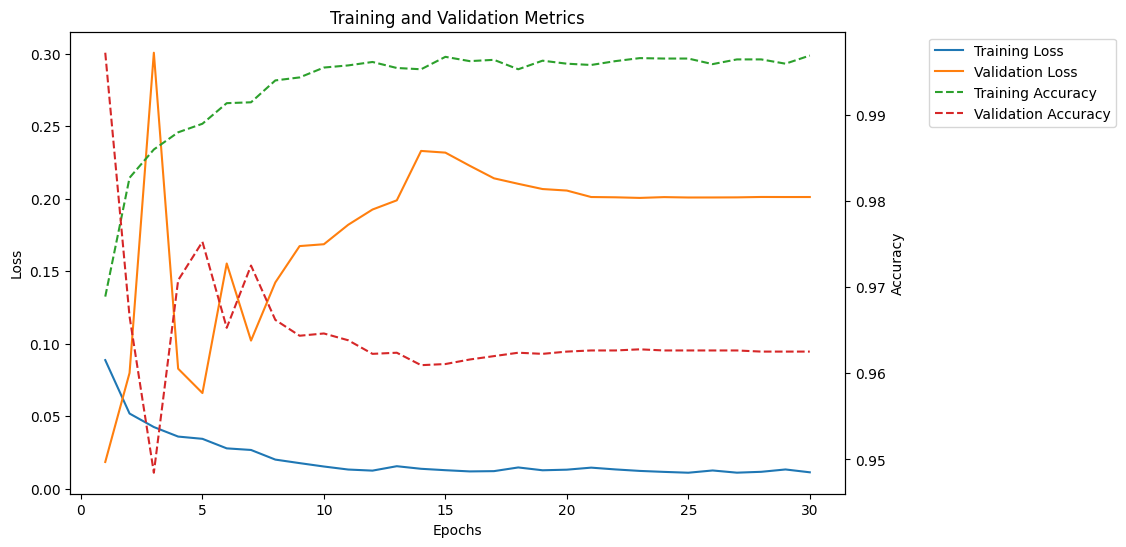

In [ ]:
import matplotlib.pyplot as plt


epochs = [1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
train_losses = trainig_loss
val_losses = val_loss
train_accuracies = train_accuracyy
val_accuracies = valid_accuracyy

fig, ax1 = plt.subplots(figsize=(10, 6))


ax1.plot(epochs, train_losses, label='Training Loss', color='tab:blue')
ax1.plot(epochs, val_losses, label='Validation Loss', color='tab:orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='black')
ax1.tick_params(axis='y', labelcolor='black')


ax2 = ax1.twinx()


ax2.plot(epochs, train_accuracies, label='Training Accuracy', linestyle='--', color='tab:green')
ax2.plot(epochs, val_accuracies, label='Validation Accuracy', linestyle='--', color='tab:red')
ax2.set_ylabel('Accuracy', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Place the legend outside the graph
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.1, 1.0))

plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')

# Show the combined plot
plt.show()
